In [ ]:
# STEP 1: Upload and unzip zip files
from google.colab import files
import zipfile
import os
from pathlib import Path

uploaded = files.upload()  # Upload your images.zip and labels.zip

os.makedirs("brain_tumor_data/images", exist_ok=True)
os.makedirs("brain_tumor_data/labels", exist_ok=True)

for fname in uploaded:
    if "image" in fname.lower():
        with zipfile.ZipFile(fname, 'r') as zip_ref:
            zip_ref.extractall("brain_tumor_data/images")
    elif "label" in fname.lower():
        with zipfile.ZipFile(fname, 'r') as zip_ref:
            zip_ref.extractall("brain_tumor_data/labels")

# STEP 2: Imports
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from tensorflow.keras import layers, regularizers, Model
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# STEP 3: Prepare Paths
images_path = Path("brain_tumor_data/images")
labels_path = Path("brain_tumor_data/labels")
image_files = list(images_path.glob("*"))
label_files = list(labels_path.glob("*"))
image_map = {p.stem: p for p in image_files}
label_map = {p.stem: p for p in label_files}

# STEP 4: Match and extract tumor presence
matched_data = []
for base_name, label_path in label_map.items():
    if base_name in image_map:
        with open(label_path, 'r') as f:
            content = f.read().strip()
            if content:
                try:
                    first_class = int(content.split()[0])
                    matched_data.append({
                        "filename": base_name,
                        "image_path": str(image_map[base_name]),
                        "label_path": str(label_path),
                        "has_tumor": int(first_class == 1)
                    })
                except ValueError:
                    print(f"⚠️ Skipping malformed label: {label_path}")

matched_df = pd.DataFrame(matched_data)
print(f"✅ Total matched samples: {len(matched_df)}")

# STEP 5: Train/Test Split
train_df, test_df = train_test_split(
    matched_df,
    test_size=0.2,
    stratify=matched_df["has_tumor"],
    random_state=42
)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# STEP 6: Image loading
IMAGE_SIZE = (224, 224)
input_shape = (224, 224, 3)

def load_image(path, size=IMAGE_SIZE):
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    return img.astype('float32')

X_train = np.array([load_image(p) for p in train_df["image_path"]])
y_train = np.array(train_df["has_tumor"]).astype(int)
X_test = np.array([load_image(p) for p in test_df["image_path"]])
y_test = np.array(test_df["has_tumor"]).astype(int)

# STEP 7: Class weights
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(f"📊 Class Weights: {class_weights_dict}")

# STEP 8: Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.3),
    layers.RandomContrast(0.1)
], name="data_augmentation")

# STEP 9: Model Architecture
base_model = EfficientNetB5(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

inputs = layers.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Lambda(lambda x: preprocess_input(x))(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# STEP 10: Training
checkpoint = ModelCheckpoint("efficientnetB5_best.keras", save_best_only=True, monitor='val_accuracy')

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[checkpoint],
    class_weight=class_weights_dict
)

# STEP 11: Evaluation
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc * 100:.2f}%")

# STEP 12: Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()

# STEP 13: Save Final Model
model.save("efficientnetB5_final.keras")

Saving labels.zip to labels.zip
Saving images.zip to images.zip
✅ Total matched samples: 0


KeyError: 'has_tumor'

Class weights: {0: np.float64(1.0477611940298508), 1: np.float64(0.9564032697547684)}
115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 320, 320, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb5 (Functional)     │ (None, 10, 10, 2048)   │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,047,544 (110.81 MB)

 Trainable params: 11,882,093 (45.33 MB)

 Non-trainable params: 17,165,451 (65.48 MB)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4871 - loss: 1.0092 - precision: 0.5092 - recall: 0.4615
Epoch 1: val_accuracy improved from -inf to 0.59659, saving model to best_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 641ms/step - accuracy: 0.4882 - loss: 1.0073 - precision: 0.5104 - recall: 0.4633 - val_accuracy: 0.5966 - val_loss: 0.7166 - val_precision: 0.5882 - val_recall: 0.7609 - learning_rate: 5.0000e-05
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5938 - loss: 0.8616 - precision: 0.6662 - recall: 0.5814
Epoch 2: val_accuracy improved from 0.59659 to 0.66477, saving model to best_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.5949 - loss: 0.8590 - precision: 0.6651 - recall: 0.5831 - val_accuracy: 0.6648 - val_loss: 0.7069 - val_precision: 0.7143 - val_recall: 0.5978 - learning_rate: 5.0000e-05
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6522 - loss: 0.7007 - precision: 0.6752 - recall: 0.6472
E

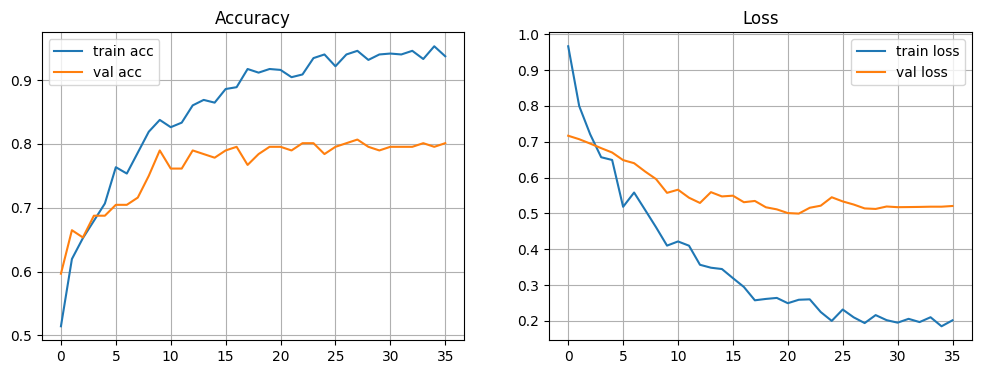

In [ ]:
# brain_tumor_detection_fixed_paths.py

import numpy as np
import pandas as pd
from pathlib import Path

import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau
)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# ─── 1. YOUR FOLDERS ─────────────────────────────────────────────────────────────

DATA_DIR = Path("/content/brain_tumor_data")
IMG_DIR  = DATA_DIR / "images" / "images"
LBL_DIR  = DATA_DIR / "labels" / "labels"

assert IMG_DIR.exists(), f"Images folder not found: {IMG_DIR}"
assert LBL_DIR.exists(), f"Labels folder not found: {LBL_DIR}"

# ─── 2. HYPERPARAMETERS ───────────────────────────────────────────────────────────

IM_SIZE     = 320
BATCH_SIZE  = 32
EPOCHS      = 50
LR          = 5e-5

# ─── 3. BUILD THE DATAFRAME ───────────────────────────────────────────────────────

def stem(p): return p.stem

# Map stems → paths
image_map = {stem(p): p for p in IMG_DIR.glob("*") if p.suffix.lower() in (".jpg", ".png", ".jpeg")}
label_map = {stem(p): p for p in LBL_DIR.glob("*.txt")}

records = []
for key, lbl_path in label_map.items():
    img_path = image_map.get(key)
    if not img_path:
        continue
    txt = lbl_path.read_text().strip()
    if not txt:
        continue
    cls = int(txt.split()[0])
    records.append({
        "image_path": str(img_path),
        "has_tumor": int(cls == 1)
    })

df = pd.DataFrame(records)
if df.empty:
    raise RuntimeError("No matching image↔label pairs found!")

train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["has_tumor"], random_state=42
)
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

# ─── 4. CLASS WEIGHTS ─────────────────────────────────────────────────────────────

cw = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["has_tumor"]),
    y=train_df["has_tumor"]
)
class_weights = dict(enumerate(cw))
print("Class weights:", class_weights)

# ─── 5. TF‑DATA PIPELINE ──────────────────────────────────────────────────────────

def tf_load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IM_SIZE, IM_SIZE])
    img = preprocess_input(img)
    return img, label

def make_ds(df, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((df["image_path"].values,
                                             df["has_tumor"].values))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=42)
    ds = ds.map(tf_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(train_df, shuffle=True)
val_ds   = make_ds(test_df, shuffle=False)

# ─── 6. MODEL DEFINITION ──────────────────────────────────────────────────────────

base = EfficientNetB5(input_shape=(IM_SIZE,IM_SIZE,3), include_top=False, weights="imagenet")
# Freeze all but the last 50 layers
for layer in base.layers[:-50]:
    layer.trainable = False
for layer in base.layers[-50:]:
    layer.trainable = True

inp = layers.Input((IM_SIZE,IM_SIZE,3))
x   = layers.RandomFlip("horizontal")(inp)
x   = layers.RandomRotation(0.1)(x)
x   = layers.RandomZoom(0.1)(x)
x   = base(x, training=True)
x   = layers.GlobalAveragePooling2D()(x)
x   = layers.BatchNormalization()(x)
x   = layers.Dropout(0.3)(x)
x   = layers.Dense(
    256,
    activation="relu",
    kernel_regularizer=regularizers.l2(1e-4)
)(x)
x   = layers.BatchNormalization()(x)
x   = layers.Dropout(0.3)(x)
out = layers.Dense(1, activation="sigmoid")(x)

model = Model(inp, out)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss="binary_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.Precision(name="precision"),
             tf.keras.metrics.Recall(name="recall")]
)
model.summary()

# ─── 7. CALLBACKS ─────────────────────────────────────────────────────────────────

callbacks = [
    ModelCheckpoint("best_model.keras", monitor="val_accuracy",
                    save_best_only=True, verbose=1),
    EarlyStopping   (monitor="val_accuracy", patience=8,
                    restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                    patience=4, verbose=1),
]

# ─── 8. TRAIN ────────────────────────────────────────────────────────────────────

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

# ─── 9. EVALUATE & PLOT ──────────────────────────────────────────────────────────

loss, acc, prec, rec = model.evaluate(val_ds, verbose=2)
print(f"\nTest accuracy: {acc*100:.2f}%  precision: {prec:.4f}  recall: {rec:.4f}")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"],  label="train acc")
plt.plot(history.history["val_accuracy"],label="val acc")
plt.title("Accuracy"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["loss"],  label="train loss")
plt.plot(history.history["val_loss"],label="val loss")
plt.title("Loss"); plt.legend(); plt.grid(True)
plt.show()

# ─── 10. SAVE FINAL ───────────────────────────────────────────────────────────────

model.save("final_model.keras")

In [ ]:
import os
import cv2
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tqdm import tqdm

# ====== STEP 1: Configuration ======
IMG_SIZE = 320
THRESHOLD = 0.5
EXTRACT_DIR = "/content/unseen_images"
MODEL_PATH = "/content/best_model.keras"

# ====== STEP 2: Load the Trained Model ======
clf_model = load_model(MODEL_PATH)

# ====== STEP 3: Preprocessing Function ======
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    h, w = img.shape
    scale = IMG_SIZE / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(img, (new_w, new_h))
    top = (IMG_SIZE - new_h) // 2
    bottom = IMG_SIZE - new_h - top
    left = (IMG_SIZE - new_w) // 2
    right = IMG_SIZE - new_w - left
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    rgb = np.repeat(padded[..., np.newaxis], 3, axis=-1)
    processed = preprocess_input(rgb.astype('float32'))
    return np.expand_dims(processed, axis=0)

# ====== STEP 4: Classification Pipeline ======
UNSEEN_SUBDIR = os.path.join(EXTRACT_DIR, "kaggle")
image_paths = sorted([os.path.join(UNSEEN_SUBDIR, f) for f in os.listdir(UNSEEN_SUBDIR)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
y_true, y_pred = [], []

print(f"\n🧪 Processing {len(image_paths)} unseen test images...\n")

for path in tqdm(image_paths):
    img_name = os.path.basename(path)
    img_tensor = preprocess_image(path)

    if img_tensor is None:
        print(f" ⚠️ Skipped: {img_name} (could not load)")
        continue

    # Run classification
    prob = clf_model.predict(img_tensor, verbose=0)[0][0]
    label = int(prob >= THRESHOLD)
    y_pred.append(label)

    # Inferred true label from filename
    gt = 1 if "tumor" in img_name.lower() else 0
    y_true.append(gt)

    print(f" 📷 {img_name} | Tumor Probability: {prob:.4f} → {'Tumor' if label else 'No Tumor'}")

# ====== STEP 5: Evaluation (if filenames have labels) ======
if y_true:
    print("\n📊 Classification Report (based on file names):")
    print(classification_report(y_true, y_pred, digits=4))

    acc = accuracy_score(y_true, y_pred)
    print(f"\n✅ Overall Classification Accuracy: {acc:.4f}")
else:
    print("\n⚠️ No ground truth inferred from filenames. Cannot evaluate metrics.")

In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.5/983.5 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.7 MB/s eta 0:00:00


In [ ]:
# ───── brain_tumor_yolo_detection_fixed.py ───────────────────────────────────────

import os
# Mitigate fragmentation (lets large tensors be split into ≤128 MiB chunks)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split

from ultralytics import YOLO

# 1) Raw data
RAW_IMG_DIR = Path("/content/brain_tumor_data/images/images")
RAW_LBL_DIR = Path("/content/brain_tumor_data/labels/labels")
assert RAW_IMG_DIR.exists()
assert RAW_LBL_DIR.exists()

# 2) YOLOv8 directory layout
BASE = Path("yolo_dataset")
for sub in ["images/train", "images/val", "labels/train", "labels/val"]:
    (BASE / sub).mkdir(parents=True, exist_ok=True)

# 3) 80/20 split
all_imgs  = sorted(RAW_IMG_DIR.glob("*.jpg"))
train_imgs, val_imgs = train_test_split(all_imgs, test_size=0.2, random_state=42)

def prepare_split(img_list, split):
    for img in img_list:
        stem = img.stem
        lbl  = RAW_LBL_DIR / f"{stem}.txt"
        dst_img = BASE / f"images/{split}" / img.name
        shutil.copy(img, dst_img)

        dst_lbl = BASE / f"labels/{split}" / f"{stem}.txt"
        if lbl.exists():
            boxes = [
                " ".join(["0"] + l.split()[1:])
                for l in lbl.read_text().splitlines()
                if l.split()[0] == "1"
            ]
            dst_lbl.write_text("\n".join(boxes))
        else:
            dst_lbl.write_text("")

prepare_split(train_imgs, "train")
prepare_split(val_imgs,   "val")

# 4) data.yaml
DATA = BASE / "data.yaml"
DATA.write_text(f"""
path: {BASE.resolve()}
train: images/train
val:   images/val
names:
  0: tumor
""".strip())


# … everything up through data.yaml generation is unchanged …

from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(
    data=str(DATA),              # path to data.yaml
    epochs=100,
    imgsz=256,
    batch=4,
    amp=True,                    # still uses mixed‑precision on CPU (optional)
    device="cpu",                # ← train on CPU
    project="runs/detect",
    name="tumor_yolo_cpu",
    exist_ok=True
)

best = YOLO("runs/detect/tumor_yolo_cpu/weights/best.pt")
best.predict(source=str(BASE/"images/val"), conf=0.25, save=True)
print("✅ Done!  Check runs/detect/tumor_yolo_cpu/predict")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 68.7MB/s]


Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=yolo_dataset/data.yaml, epochs=100, time=None, patience=100, batch=4, imgsz=256, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=runs/detect, name=tumor_yolo_cpu, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line

100%|██████████| 755k/755k [00:00<00:00, 14.2MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 228.4±121.1 MB/s, size: 4.7 KB)


train: Scanning /content/yolo_dataset/labels/train... 714 images, 346 backgrounds, 0 corrupt: 100%|██████████| 714/714 [00:00<00:00, 1896.57it/s]

train: New cache created: /content/yolo_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 159.1±93.3 MB/s, size: 3.0 KB)


val: Scanning /content/yolo_dataset/labels/val... 179 images, 88 backgrounds, 0 corrupt: 100%|██████████| 179/179 [00:00<00:00, 1922.35it/s]

val: New cache created: /content/yolo_dataset/labels/val.cache


Plotting labels to runs/detect/tumor_yolo_cpu/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 0 dataloader workers
Logging results to runs/detect/tumor_yolo_cpu
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.742      3.276      1.155          3        256: 100%|██████████| 179/179 [00:36<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:03<00:00,  6.65it/s]


                   all        179         93      0.534      0.419      0.444      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.588      2.574      1.055          1        256: 100%|██████████| 179/179 [00:34<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]

                   all        179         93      0.454      0.581      0.492      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.843      2.368      1.171          2        256: 100%|██████████| 179/179 [00:34<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.76it/s]

                   all        179         93      0.378      0.692      0.453      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G       1.69      2.067      1.128          0        256: 100%|██████████| 179/179 [00:34<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.91it/s]

                   all        179         93      0.511      0.677      0.545      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.702      1.984      1.143          3        256: 100%|██████████| 179/179 [00:33<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.70it/s]

                   all        179         93      0.558      0.699      0.561      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.725      1.793      1.137          1        256: 100%|██████████| 179/179 [00:34<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.69it/s]

                   all        179         93      0.514       0.71      0.557      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.574      1.776      1.042          0        256: 100%|██████████| 179/179 [00:34<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.81it/s]

                   all        179         93       0.49      0.703      0.482        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.547      1.713       1.06          3        256: 100%|██████████| 179/179 [00:34<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.90it/s]

                   all        179         93      0.586      0.785       0.59      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.549      1.711      1.091          2        256: 100%|██████████| 179/179 [00:34<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]

                   all        179         93      0.481      0.727      0.525      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.535       1.72      1.094          1        256: 100%|██████████| 179/179 [00:34<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.74it/s]

                   all        179         93      0.538      0.817      0.631      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.578      1.696      1.075          0        256: 100%|██████████| 179/179 [00:34<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.65it/s]

                   all        179         93      0.466      0.688       0.53      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.463      1.568      1.044          6        256: 100%|██████████| 179/179 [00:35<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.79it/s]

                   all        179         93      0.502      0.742      0.613       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.489      1.644      1.092          2        256: 100%|██████████| 179/179 [00:34<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]

                   all        179         93      0.479      0.819      0.547      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.452      1.558      1.056          2        256: 100%|██████████| 179/179 [00:34<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.56it/s]

                   all        179         93      0.511      0.753      0.563      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G       1.43      1.547      1.048          2        256: 100%|██████████| 179/179 [00:34<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.91it/s]

                   all        179         93      0.521      0.882      0.612      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.467      1.628      1.012          1        256: 100%|██████████| 179/179 [00:33<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.64it/s]

                   all        179         93      0.487      0.828       0.58      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.353      1.627      1.024          2        256: 100%|██████████| 179/179 [00:34<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.70it/s]

                   all        179         93      0.519       0.86      0.638      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.324      1.483     0.9832          0        256: 100%|██████████| 179/179 [00:34<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.74it/s]

                   all        179         93      0.553      0.742       0.62      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.324      1.564     0.9822          2        256: 100%|██████████| 179/179 [00:34<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.55it/s]

                   all        179         93      0.527       0.79      0.606      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.318      1.405     0.9929          1        256: 100%|██████████| 179/179 [00:34<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.14it/s]

                   all        179         93       0.55      0.871      0.641      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.436      1.527      1.029          3        256: 100%|██████████| 179/179 [00:34<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.68it/s]

                   all        179         93      0.529      0.784      0.639        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.305      1.467     0.9881          2        256: 100%|██████████| 179/179 [00:34<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.69it/s]

                   all        179         93      0.538       0.86      0.622      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.285      1.447      1.014          0        256: 100%|██████████| 179/179 [00:34<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.89it/s]

                   all        179         93      0.486      0.839      0.635      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.269      1.483     0.9736          0        256: 100%|██████████| 179/179 [00:35<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.44it/s]

                   all        179         93        0.5       0.86       0.66      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.248      1.332     0.9789          1        256: 100%|██████████| 179/179 [00:34<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.84it/s]

                   all        179         93      0.514      0.796      0.634      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.252      1.393     0.9934          1        256: 100%|██████████| 179/179 [00:34<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.86it/s]

                   all        179         93      0.473      0.763      0.607      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.358      1.471      1.006          3        256: 100%|██████████| 179/179 [00:35<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]

                   all        179         93      0.506      0.839      0.616      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.232      1.386     0.9714          1        256: 100%|██████████| 179/179 [00:33<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]

                   all        179         93        0.5      0.763      0.642      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.264      1.434     0.9437          1        256: 100%|██████████| 179/179 [00:34<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.35it/s]

                   all        179         93      0.481      0.828      0.554      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G       1.28      1.384     0.9772          1        256: 100%|██████████| 179/179 [00:35<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.66it/s]

                   all        179         93      0.497      0.838      0.573      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.222      1.513     0.9081          2        256: 100%|██████████| 179/179 [00:35<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.84it/s]

                   all        179         93      0.481      0.809      0.614      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.243      1.309     0.9735          3        256: 100%|██████████| 179/179 [00:34<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.80it/s]

                   all        179         93      0.509      0.857      0.618      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.272      1.542     0.9627          0        256: 100%|██████████| 179/179 [00:34<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.27it/s]

                   all        179         93      0.537      0.796      0.577      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.198      1.367     0.9335          3        256: 100%|██████████| 179/179 [00:34<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.98it/s]

                   all        179         93      0.474      0.871      0.586      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.312      1.357      1.023          5        256: 100%|██████████| 179/179 [00:34<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.93it/s]

                   all        179         93      0.465      0.849      0.579      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.253      1.298     0.9866          0        256: 100%|██████████| 179/179 [00:32<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.96it/s]

                   all        179         93      0.506      0.848      0.614      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.252      1.402     0.9874          5        256: 100%|██████████| 179/179 [00:34<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.34it/s]

                   all        179         93      0.506      0.892      0.644      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      1.259      1.394     0.9615          4        256: 100%|██████████| 179/179 [00:34<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.87it/s]

                   all        179         93      0.485      0.828      0.627      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      1.143      1.287     0.9461          4        256: 100%|██████████| 179/179 [00:34<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.89it/s]

                   all        179         93      0.516      0.836      0.632      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.085      1.313     0.8914          1        256: 100%|██████████| 179/179 [00:34<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.99it/s]

                   all        179         93      0.505      0.882      0.641      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      1.208      1.416      0.971          0        256: 100%|██████████| 179/179 [00:33<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.76it/s]

                   all        179         93       0.59      0.681      0.643      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      1.191      1.395     0.9751          1        256: 100%|██████████| 179/179 [00:33<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.12it/s]

                   all        179         93       0.53      0.777      0.636      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      1.202      1.284     0.9724          3        256: 100%|██████████| 179/179 [00:34<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.98it/s]

                   all        179         93      0.507      0.864      0.638       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      1.176      1.281     0.9806          2        256: 100%|██████████| 179/179 [00:33<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.01it/s]

                   all        179         93      0.517      0.828      0.653       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      1.111      1.219     0.9336          0        256: 100%|██████████| 179/179 [00:33<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.60it/s]

                   all        179         93      0.504      0.806      0.597       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G      1.232      1.317     0.9597          1        256: 100%|██████████| 179/179 [00:33<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.98it/s]

                   all        179         93        0.5      0.849       0.62       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      1.227      1.354     0.9363          2        256: 100%|██████████| 179/179 [00:33<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.17it/s]

                   all        179         93      0.529      0.849      0.628      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G      1.201      1.336     0.9838          2        256: 100%|██████████| 179/179 [00:33<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.54it/s]

                   all        179         93      0.491      0.806      0.638       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G      1.149      1.404     0.9276          1        256: 100%|██████████| 179/179 [00:34<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.98it/s]

                   all        179         93      0.502      0.785      0.623      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G       1.21      1.376     0.9576          2        256: 100%|██████████| 179/179 [00:33<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]

                   all        179         93      0.513      0.781      0.574      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G      1.146      1.312     0.9183          1        256: 100%|██████████| 179/179 [00:33<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.67it/s]

                   all        179         93      0.496      0.828      0.635      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      1.181       1.24     0.9603          3        256: 100%|██████████| 179/179 [00:33<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.11it/s]

                   all        179         93      0.529      0.817      0.644      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G      1.193      1.304     0.9638          1        256: 100%|██████████| 179/179 [00:34<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.04it/s]

                   all        179         93      0.513      0.769      0.639       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G      1.129      1.232      0.949          2        256: 100%|██████████| 179/179 [00:34<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.10it/s]

                   all        179         93      0.494      0.882       0.65      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G      1.192      1.384     0.9493          2        256: 100%|██████████| 179/179 [00:33<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.02it/s]

                   all        179         93      0.544       0.71      0.626      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G      1.178      1.256      0.959          1        256: 100%|██████████| 179/179 [00:33<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.36it/s]

                   all        179         93      0.529       0.86      0.683      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G      1.119      1.254     0.9127          1        256: 100%|██████████| 179/179 [00:34<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.27it/s]

                   all        179         93      0.532      0.817      0.644      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G      1.134      1.262     0.9219          1        256: 100%|██████████| 179/179 [00:34<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.88it/s]

                   all        179         93      0.593      0.817      0.687      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G      1.171      1.294     0.9372          1        256: 100%|██████████| 179/179 [00:34<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.00it/s]

                   all        179         93      0.547       0.86      0.662      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G      1.058      1.205     0.9334          1        256: 100%|██████████| 179/179 [00:33<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]

                   all        179         93      0.536      0.806      0.695      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G      1.129      1.222     0.9449          3        256: 100%|██████████| 179/179 [00:34<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.89it/s]

                   all        179         93       0.55      0.796      0.695       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      1.112      1.214      0.946          5        256: 100%|██████████| 179/179 [00:34<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.82it/s]

                   all        179         93       0.54      0.849      0.676      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G      1.139      1.238     0.9484          3        256: 100%|██████████| 179/179 [00:34<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.59it/s]

                   all        179         93      0.577      0.763      0.677       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      1.051      1.216     0.9089          2        256: 100%|██████████| 179/179 [00:34<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]

                   all        179         93      0.543      0.828      0.644      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G      1.099      1.256     0.9257          1        256: 100%|██████████| 179/179 [00:34<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.92it/s]

                   all        179         93      0.612      0.731      0.672      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G      1.104      1.264      0.915          1        256: 100%|██████████| 179/179 [00:34<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.70it/s]

                   all        179         93       0.58      0.785      0.658      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G          1      1.178      0.882          0        256: 100%|██████████| 179/179 [00:34<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.65it/s]

                   all        179         93      0.548      0.821      0.663       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G      1.015      1.082     0.9046          0        256: 100%|██████████| 179/179 [00:34<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.82it/s]

                   all        179         93      0.539      0.768      0.661      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G      1.082      1.166      0.916          0        256: 100%|██████████| 179/179 [00:34<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.27it/s]

                   all        179         93      0.535      0.853      0.679      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G      1.047      1.203      0.919          1        256: 100%|██████████| 179/179 [00:34<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.40it/s]

                   all        179         93      0.585      0.818      0.704      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G     0.9964      1.203     0.8734          1        256: 100%|██████████| 179/179 [00:34<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.96it/s]

                   all        179         93      0.656      0.678       0.69      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G      1.042      1.108     0.9124          0        256: 100%|██████████| 179/179 [00:35<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.53it/s]

                   all        179         93      0.641      0.742      0.687      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G      1.017      1.079     0.9022          2        256: 100%|██████████| 179/179 [00:34<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.68it/s]

                   all        179         93      0.569      0.731      0.642      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G      1.093      1.158     0.9324          4        256: 100%|██████████| 179/179 [00:35<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.37it/s]

                   all        179         93       0.63      0.714      0.666      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G      1.078      1.094     0.9198          5        256: 100%|██████████| 179/179 [00:35<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.57it/s]

                   all        179         93      0.567      0.753      0.669      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G      1.078      1.225     0.9164          3        256: 100%|██████████| 179/179 [00:35<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.97it/s]

                   all        179         93      0.586      0.731      0.655      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G      1.043      1.162     0.9005          2        256: 100%|██████████| 179/179 [00:35<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]

                   all        179         93      0.614      0.787      0.705      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G      1.077      1.124       0.92          3        256: 100%|██████████| 179/179 [00:35<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.82it/s]

                   all        179         93      0.636      0.752      0.696      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G       1.05      1.164     0.9061          1        256: 100%|██████████| 179/179 [00:36<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.62it/s]

                   all        179         93      0.594      0.753       0.72       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G      1.022      1.159     0.8923          2        256: 100%|██████████| 179/179 [00:35<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]

                   all        179         93      0.611      0.753      0.705      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G      1.057      1.132      0.936          4        256: 100%|██████████| 179/179 [00:35<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]

                   all        179         93      0.562      0.785      0.693      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G      1.001      1.093     0.9088          1        256: 100%|██████████| 179/179 [00:34<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.12it/s]

                   all        179         93      0.606      0.793      0.719      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G      1.026      0.993     0.9147          0        256: 100%|██████████| 179/179 [00:35<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.72it/s]

                   all        179         93       0.63      0.768      0.719      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G      1.061      1.076     0.9306          1        256: 100%|██████████| 179/179 [00:35<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  7.95it/s]

                   all        179         93      0.716      0.645       0.72      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G     0.9737     0.9797      0.926          3        256: 100%|██████████| 179/179 [00:35<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.08it/s]

                   all        179         93      0.679      0.705       0.73      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G       1.04       1.07      0.903          1        256: 100%|██████████| 179/179 [00:36<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.43it/s]

                   all        179         93      0.669      0.699      0.704      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G      1.006      1.117     0.8981          1        256: 100%|██████████| 179/179 [00:36<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.12it/s]

                   all        179         93      0.601      0.774      0.728      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G       1.02      1.019     0.9175          1        256: 100%|██████████| 179/179 [00:35<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]

                   all        179         93      0.587      0.817      0.719      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G      1.011      1.026     0.9032          0        256: 100%|██████████| 179/179 [00:35<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]

                   all        179         93      0.684      0.677      0.709      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G     0.9763      1.045     0.9091          1        256: 100%|██████████| 179/179 [00:35<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]

                   all        179         93      0.661      0.731       0.74      0.553


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G     0.8785       1.06     0.8505          0        256: 100%|██████████| 179/179 [00:35<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.59it/s]

                   all        179         93      0.624      0.774      0.695      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G      0.898      1.116     0.8397          3        256: 100%|██████████| 179/179 [00:35<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]

                   all        179         93      0.559      0.774      0.699      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G     0.8842      1.002     0.8531          0        256: 100%|██████████| 179/179 [00:35<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.67it/s]

                   all        179         93      0.603      0.763      0.723      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G      0.862      1.059     0.8588          2        256: 100%|██████████| 179/179 [00:34<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  7.92it/s]

                   all        179         93      0.597      0.796      0.717      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G     0.8721      1.014     0.8682          1        256: 100%|██████████| 179/179 [00:35<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]

                   all        179         93       0.63      0.786      0.724      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G     0.8519     0.8783     0.8626          1        256: 100%|██████████| 179/179 [00:35<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


                   all        179         93      0.624      0.763      0.735      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G     0.8567     0.9572      0.875          2        256: 100%|██████████| 179/179 [00:35<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.63it/s]

                   all        179         93      0.703      0.688      0.744      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G     0.8283     0.9828     0.8352          1        256: 100%|██████████| 179/179 [00:35<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.17it/s]

                   all        179         93      0.648      0.742      0.748      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G     0.8605     0.9173     0.8487          1        256: 100%|██████████| 179/179 [00:35<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.77it/s]

                   all        179         93      0.618      0.816      0.744      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G       0.84     0.9946     0.8245          3        256: 100%|██████████| 179/179 [00:35<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.22it/s]

                   all        179         93      0.619      0.774      0.746      0.564



100 epochs completed in 1.042 hours.
Optimizer stripped from runs/detect/tumor_yolo_cpu/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/tumor_yolo_cpu/weights/best.pt, 6.2MB

Validating runs/detect/tumor_yolo_cpu/weights/best.pt...
Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.26it/s]


                   all        179         93      0.618      0.816      0.743      0.567
Speed: 0.2ms preprocess, 9.9ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/tumor_yolo_cpu


AssertionError: Invalid device id


🧪 Processing 223 unseen test images...



  1%|          | 2/223 [00:05<08:20,  2.26s/it]

 📷 val_1 (1).jpg | Tumor Probability: 0.9407 → Tumor
 📷 val_1 (10).jpg | Tumor Probability: 0.2756 → No Tumor
 📷 val_1 (100).jpg | Tumor Probability: 0.7424 → Tumor


  3%|▎         | 6/223 [00:05<01:53,  1.91it/s]

 📷 val_1 (101).jpg | Tumor Probability: 0.0385 → No Tumor
 📷 val_1 (102).jpg | Tumor Probability: 0.8806 → Tumor
 📷 val_1 (103).jpg | Tumor Probability: 0.5219 → Tumor


  4%|▎         | 8/223 [00:06<01:15,  2.84it/s]

 📷 val_1 (104).jpg | Tumor Probability: 0.7310 → Tumor
 📷 val_1 (105).jpg | Tumor Probability: 0.2930 → No Tumor
 📷 val_1 (106).jpg | Tumor Probability: 0.0650 → No Tumor


  5%|▌         | 12/223 [00:06<00:42,  4.96it/s]

 📷 val_1 (107).jpg | Tumor Probability: 0.8320 → Tumor
 📷 val_1 (108).jpg | Tumor Probability: 0.3555 → No Tumor
 📷 val_1 (109).jpg | Tumor Probability: 0.6196 → Tumor


  6%|▋         | 14/223 [00:06<00:34,  6.01it/s]

 📷 val_1 (11).jpg | Tumor Probability: 0.0221 → No Tumor
 📷 val_1 (110).jpg | Tumor Probability: 0.8160 → Tumor
 📷 val_1 (111).jpg | Tumor Probability: 0.3715 → No Tumor


  8%|▊         | 18/223 [00:06<00:26,  7.87it/s]

 📷 val_1 (112).jpg | Tumor Probability: 0.6402 → Tumor
 📷 val_1 (113).jpg | Tumor Probability: 0.6693 → Tumor
 📷 val_1 (114).jpg | Tumor Probability: 0.7533 → Tumor


  9%|▉         | 20/223 [00:07<00:23,  8.54it/s]

 📷 val_1 (115).jpg | Tumor Probability: 0.9168 → Tumor
 📷 val_1 (116).jpg | Tumor Probability: 0.9969 → Tumor
 📷 val_1 (117).jpg | Tumor Probability: 0.7534 → Tumor


 11%|█         | 24/223 [00:07<00:21,  9.42it/s]

 📷 val_1 (118).jpg | Tumor Probability: 0.3430 → No Tumor
 📷 val_1 (119).jpg | Tumor Probability: 0.0259 → No Tumor
 📷 val_1 (12).jpg | Tumor Probability: 0.0175 → No Tumor


 12%|█▏        | 26/223 [00:07<00:20,  9.73it/s]

 📷 val_1 (120).jpg | Tumor Probability: 0.2277 → No Tumor
 📷 val_1 (121).jpg | Tumor Probability: 0.1998 → No Tumor
 📷 val_1 (122).jpg | Tumor Probability: 0.9926 → Tumor


 13%|█▎        | 30/223 [00:08<00:18, 10.17it/s]

 📷 val_1 (123).jpg | Tumor Probability: 0.5151 → Tumor
 📷 val_1 (124).jpg | Tumor Probability: 0.7977 → Tumor
 📷 val_1 (125).jpg | Tumor Probability: 0.9883 → Tumor


 14%|█▍        | 32/223 [00:08<00:18, 10.38it/s]

 📷 val_1 (126).jpg | Tumor Probability: 0.6450 → Tumor
 📷 val_1 (127).jpg | Tumor Probability: 0.5784 → Tumor
 📷 val_1 (128).jpg | Tumor Probability: 0.1730 → No Tumor


 16%|█▌        | 36/223 [00:08<00:17, 10.62it/s]

 📷 val_1 (129).jpg | Tumor Probability: 0.0631 → No Tumor
 📷 val_1 (13).jpg | Tumor Probability: 0.7528 → Tumor
 📷 val_1 (130).jpg | Tumor Probability: 0.0268 → No Tumor


 17%|█▋        | 38/223 [00:08<00:17, 10.71it/s]

 📷 val_1 (131).jpg | Tumor Probability: 0.4456 → No Tumor
 📷 val_1 (132).jpg | Tumor Probability: 0.3929 → No Tumor
 📷 val_1 (133).jpg | Tumor Probability: 0.7208 → Tumor


 19%|█▉        | 42/223 [00:09<00:16, 10.91it/s]

 📷 val_1 (134).jpg | Tumor Probability: 0.8817 → Tumor
 📷 val_1 (135).jpg | Tumor Probability: 0.9068 → Tumor
 📷 val_1 (136).jpg | Tumor Probability: 0.1094 → No Tumor


 20%|█▉        | 44/223 [00:09<00:16, 10.96it/s]

 📷 val_1 (137).jpg | Tumor Probability: 0.7535 → Tumor
 📷 val_1 (138).jpg | Tumor Probability: 0.1343 → No Tumor
 📷 val_1 (139).jpg | Tumor Probability: 0.9709 → Tumor


 22%|██▏       | 48/223 [00:09<00:15, 11.01it/s]

 📷 val_1 (14).jpg | Tumor Probability: 0.4131 → No Tumor
 📷 val_1 (140).jpg | Tumor Probability: 0.9907 → Tumor
 📷 val_1 (141).jpg | Tumor Probability: 0.4734 → No Tumor


 22%|██▏       | 50/223 [00:09<00:15, 10.98it/s]

 📷 val_1 (142).jpg | Tumor Probability: 0.7733 → Tumor
 📷 val_1 (143).jpg | Tumor Probability: 0.7158 → Tumor
 📷 val_1 (144).jpg | Tumor Probability: 0.4640 → No Tumor


 24%|██▍       | 54/223 [00:10<00:15, 10.92it/s]

 📷 val_1 (145).jpg | Tumor Probability: 0.1320 → No Tumor
 📷 val_1 (146).jpg | Tumor Probability: 0.9792 → Tumor
 📷 val_1 (147).jpg | Tumor Probability: 0.0862 → No Tumor


 25%|██▌       | 56/223 [00:10<00:15, 10.93it/s]

 📷 val_1 (148).jpg | Tumor Probability: 0.0687 → No Tumor
 📷 val_1 (149).jpg | Tumor Probability: 0.0857 → No Tumor
 📷 val_1 (15).jpg | Tumor Probability: 0.4867 → No Tumor


 27%|██▋       | 60/223 [00:10<00:14, 10.89it/s]

 📷 val_1 (150).jpg | Tumor Probability: 0.9521 → Tumor
 📷 val_1 (151).jpg | Tumor Probability: 0.6841 → Tumor
 📷 val_1 (152).jpg | Tumor Probability: 0.4826 → No Tumor


 28%|██▊       | 62/223 [00:11<00:14, 10.88it/s]

 📷 val_1 (153).jpg | Tumor Probability: 0.0921 → No Tumor
 📷 val_1 (154).jpg | Tumor Probability: 0.0218 → No Tumor
 📷 val_1 (155).jpg | Tumor Probability: 0.0514 → No Tumor


 30%|██▉       | 66/223 [00:11<00:14, 10.88it/s]

 📷 val_1 (156).jpg | Tumor Probability: 0.3357 → No Tumor
 📷 val_1 (157).jpg | Tumor Probability: 0.9823 → Tumor
 📷 val_1 (158).jpg | Tumor Probability: 0.7717 → Tumor


 30%|███       | 68/223 [00:11<00:14, 10.92it/s]

 📷 val_1 (159).jpg | Tumor Probability: 0.1462 → No Tumor
 📷 val_1 (16).jpg | Tumor Probability: 0.7139 → Tumor
 📷 val_1 (160).jpg | Tumor Probability: 0.0018 → No Tumor


 32%|███▏      | 72/223 [00:11<00:13, 10.90it/s]

 📷 val_1 (161).jpg | Tumor Probability: 0.0892 → No Tumor
 📷 val_1 (162).jpg | Tumor Probability: 0.3976 → No Tumor
 📷 val_1 (163).jpg | Tumor Probability: 0.0110 → No Tumor


 33%|███▎      | 74/223 [00:12<00:13, 10.89it/s]

 📷 val_1 (164).jpg | Tumor Probability: 0.4945 → No Tumor
 📷 val_1 (165).jpg | Tumor Probability: 0.0399 → No Tumor
 📷 val_1 (166).jpg | Tumor Probability: 0.8979 → Tumor


 35%|███▍      | 78/223 [00:12<00:13, 10.94it/s]

 📷 val_1 (167).jpg | Tumor Probability: 0.9997 → Tumor
 📷 val_1 (168).jpg | Tumor Probability: 0.6135 → Tumor
 📷 val_1 (169).jpg | Tumor Probability: 0.9988 → Tumor


 36%|███▌      | 80/223 [00:12<00:13, 10.90it/s]

 📷 val_1 (17).jpg | Tumor Probability: 0.6478 → Tumor
 📷 val_1 (170).jpg | Tumor Probability: 0.1031 → No Tumor
 📷 val_1 (171).jpg | Tumor Probability: 0.5688 → Tumor


 38%|███▊      | 84/223 [00:13<00:12, 10.98it/s]

 📷 val_1 (172).jpg | Tumor Probability: 0.9377 → Tumor
 📷 val_1 (173).jpg | Tumor Probability: 0.9916 → Tumor
 📷 val_1 (174).jpg | Tumor Probability: 0.0006 → No Tumor


 39%|███▊      | 86/223 [00:13<00:12, 11.05it/s]

 📷 val_1 (175).jpg | Tumor Probability: 0.0024 → No Tumor
 📷 val_1 (176).jpg | Tumor Probability: 0.0036 → No Tumor
 📷 val_1 (177).jpg | Tumor Probability: 0.0055 → No Tumor


 40%|████      | 90/223 [00:13<00:12, 11.01it/s]

 📷 val_1 (178).jpg | Tumor Probability: 0.3426 → No Tumor
 📷 val_1 (179).jpg | Tumor Probability: 0.9991 → Tumor
 📷 val_1 (18).jpg | Tumor Probability: 0.1717 → No Tumor


 41%|████▏     | 92/223 [00:13<00:11, 11.02it/s]

 📷 val_1 (180).jpg | Tumor Probability: 0.9520 → Tumor
 📷 val_1 (181).jpg | Tumor Probability: 0.8130 → Tumor
 📷 val_1 (182).jpg | Tumor Probability: 0.5572 → Tumor


 43%|████▎     | 96/223 [00:14<00:11, 11.02it/s]

 📷 val_1 (183).jpg | Tumor Probability: 0.6826 → Tumor
 📷 val_1 (184).jpg | Tumor Probability: 0.4197 → No Tumor
 📷 val_1 (185).jpg | Tumor Probability: 0.6364 → Tumor


 44%|████▍     | 98/223 [00:14<00:11, 11.01it/s]

 📷 val_1 (186).jpg | Tumor Probability: 0.2204 → No Tumor
 📷 val_1 (187).jpg | Tumor Probability: 0.3384 → No Tumor
 📷 val_1 (188).jpg | Tumor Probability: 0.0006 → No Tumor


 46%|████▌     | 102/223 [00:14<00:11, 10.85it/s]

 📷 val_1 (189).jpg | Tumor Probability: 0.3599 → No Tumor
 📷 val_1 (19).jpg | Tumor Probability: 0.1909 → No Tumor
 📷 val_1 (190).jpg | Tumor Probability: 0.1237 → No Tumor


 47%|████▋     | 104/223 [00:14<00:10, 10.90it/s]

 📷 val_1 (191).jpg | Tumor Probability: 0.4226 → No Tumor
 📷 val_1 (192).jpg | Tumor Probability: 0.5766 → Tumor
 📷 val_1 (193).jpg | Tumor Probability: 0.0463 → No Tumor


 48%|████▊     | 108/223 [00:15<00:10, 10.88it/s]

 📷 val_1 (194).jpg | Tumor Probability: 0.0308 → No Tumor
 📷 val_1 (195).jpg | Tumor Probability: 0.0406 → No Tumor
 📷 val_1 (196).jpg | Tumor Probability: 0.0744 → No Tumor


 49%|████▉     | 110/223 [00:15<00:10, 10.93it/s]

 📷 val_1 (197).jpg | Tumor Probability: 0.0133 → No Tumor
 📷 val_1 (198).jpg | Tumor Probability: 0.0158 → No Tumor
 📷 val_1 (199).jpg | Tumor Probability: 0.0179 → No Tumor


 51%|█████     | 114/223 [00:15<00:10, 10.66it/s]

 📷 val_1 (2).jpg | Tumor Probability: 0.9702 → Tumor
 📷 val_1 (20).jpg | Tumor Probability: 0.8273 → Tumor
 📷 val_1 (200).jpg | Tumor Probability: 0.3962 → No Tumor


 52%|█████▏    | 116/223 [00:15<00:09, 10.76it/s]

 📷 val_1 (201).jpg | Tumor Probability: 0.3725 → No Tumor
 📷 val_1 (202).jpg | Tumor Probability: 0.7480 → Tumor
 📷 val_1 (203).jpg | Tumor Probability: 0.0026 → No Tumor


 54%|█████▍    | 120/223 [00:16<00:09, 10.87it/s]

 📷 val_1 (204).jpg | Tumor Probability: 0.0201 → No Tumor
 📷 val_1 (205).jpg | Tumor Probability: 0.0448 → No Tumor
 📷 val_1 (206).jpg | Tumor Probability: 0.1157 → No Tumor


 55%|█████▍    | 122/223 [00:16<00:09, 11.00it/s]

 📷 val_1 (207).jpg | Tumor Probability: 0.0086 → No Tumor
 📷 val_1 (208).jpg | Tumor Probability: 0.5606 → Tumor
 📷 val_1 (209).jpg | Tumor Probability: 0.1236 → No Tumor


 57%|█████▋    | 126/223 [00:16<00:08, 11.07it/s]

 📷 val_1 (21).jpg | Tumor Probability: 0.4693 → No Tumor
 📷 val_1 (210).jpg | Tumor Probability: 0.1692 → No Tumor
 📷 val_1 (211).jpg | Tumor Probability: 0.9723 → Tumor


 57%|█████▋    | 128/223 [00:17<00:08, 11.13it/s]

 📷 val_1 (212).jpg | Tumor Probability: 0.0049 → No Tumor
 📷 val_1 (213).jpg | Tumor Probability: 0.0034 → No Tumor
 📷 val_1 (214).jpg | Tumor Probability: 0.0024 → No Tumor


 59%|█████▉    | 132/223 [00:17<00:08, 11.12it/s]

 📷 val_1 (215).jpg | Tumor Probability: 0.0575 → No Tumor
 📷 val_1 (216).jpg | Tumor Probability: 0.0287 → No Tumor
 📷 val_1 (217).jpg | Tumor Probability: 0.0432 → No Tumor


 60%|██████    | 134/223 [00:17<00:07, 11.15it/s]

 📷 val_1 (218).jpg | Tumor Probability: 0.1065 → No Tumor
 📷 val_1 (219).jpg | Tumor Probability: 0.0937 → No Tumor
 📷 val_1 (22).jpg | Tumor Probability: 0.9083 → Tumor


 62%|██████▏   | 138/223 [00:17<00:07, 11.09it/s]

 📷 val_1 (220).jpg | Tumor Probability: 0.0936 → No Tumor
 📷 val_1 (221).jpg | Tumor Probability: 0.0859 → No Tumor
 📷 val_1 (222).jpg | Tumor Probability: 0.0355 → No Tumor


 63%|██████▎   | 140/223 [00:18<00:07, 11.06it/s]

 📷 val_1 (223).jpg | Tumor Probability: 0.0237 → No Tumor
 📷 val_1 (23).jpg | Tumor Probability: 0.0461 → No Tumor
 📷 val_1 (24).jpg | Tumor Probability: 0.4676 → No Tumor


 65%|██████▍   | 144/223 [00:18<00:07, 11.12it/s]

 📷 val_1 (25).jpg | Tumor Probability: 0.6880 → Tumor
 📷 val_1 (26).jpg | Tumor Probability: 0.0207 → No Tumor
 📷 val_1 (27).jpg | Tumor Probability: 0.0109 → No Tumor


 65%|██████▌   | 146/223 [00:18<00:06, 11.06it/s]

 📷 val_1 (28).jpg | Tumor Probability: 0.2384 → No Tumor
 📷 val_1 (29).jpg | Tumor Probability: 0.1353 → No Tumor
 📷 val_1 (3).jpg | Tumor Probability: 0.7130 → Tumor


 67%|██████▋   | 150/223 [00:19<00:06, 11.09it/s]

 📷 val_1 (30).jpg | Tumor Probability: 0.0019 → No Tumor
 📷 val_1 (31).jpg | Tumor Probability: 0.0007 → No Tumor
 📷 val_1 (32).jpg | Tumor Probability: 0.0066 → No Tumor


 68%|██████▊   | 152/223 [00:19<00:06, 11.11it/s]

 📷 val_1 (33).jpg | Tumor Probability: 0.0624 → No Tumor
 📷 val_1 (34).jpg | Tumor Probability: 0.1612 → No Tumor
 📷 val_1 (35).jpg | Tumor Probability: 0.6779 → Tumor


 70%|██████▉   | 156/223 [00:19<00:05, 11.28it/s]

 📷 val_1 (36).jpg | Tumor Probability: 0.9833 → Tumor
 📷 val_1 (37).jpg | Tumor Probability: 0.3194 → No Tumor
 📷 val_1 (38).jpg | Tumor Probability: 0.2768 → No Tumor


 71%|███████   | 158/223 [00:19<00:05, 11.23it/s]

 📷 val_1 (39).jpg | Tumor Probability: 0.1601 → No Tumor
 📷 val_1 (4).jpg | Tumor Probability: 0.4309 → No Tumor
 📷 val_1 (40).jpg | Tumor Probability: 0.2942 → No Tumor


 73%|███████▎  | 162/223 [00:20<00:05, 11.13it/s]

 📷 val_1 (41).jpg | Tumor Probability: 0.0412 → No Tumor
 📷 val_1 (42).jpg | Tumor Probability: 0.1964 → No Tumor
 📷 val_1 (43).jpg | Tumor Probability: 0.9762 → Tumor


 74%|███████▎  | 164/223 [00:20<00:05, 11.13it/s]

 📷 val_1 (44).jpg | Tumor Probability: 0.2115 → No Tumor
 📷 val_1 (45).jpg | Tumor Probability: 0.4044 → No Tumor
 📷 val_1 (46).jpg | Tumor Probability: 0.4780 → No Tumor


 75%|███████▌  | 168/223 [00:20<00:04, 11.14it/s]

 📷 val_1 (47).jpg | Tumor Probability: 0.4146 → No Tumor
 📷 val_1 (48).jpg | Tumor Probability: 0.5459 → Tumor
 📷 val_1 (49).jpg | Tumor Probability: 0.5904 → Tumor


 76%|███████▌  | 170/223 [00:20<00:04, 11.12it/s]

 📷 val_1 (5).jpg | Tumor Probability: 0.5591 → Tumor
 📷 val_1 (50).jpg | Tumor Probability: 0.9838 → Tumor
 📷 val_1 (51).jpg | Tumor Probability: 0.9795 → Tumor


 78%|███████▊  | 174/223 [00:21<00:04, 11.19it/s]

 📷 val_1 (52).jpg | Tumor Probability: 0.9541 → Tumor
 📷 val_1 (53).jpg | Tumor Probability: 0.8302 → Tumor
 📷 val_1 (54).jpg | Tumor Probability: 0.4086 → No Tumor


 79%|███████▉  | 176/223 [00:21<00:04, 11.13it/s]

 📷 val_1 (55).jpg | Tumor Probability: 0.7958 → Tumor
 📷 val_1 (56).jpg | Tumor Probability: 0.5462 → Tumor
 📷 val_1 (57).jpg | Tumor Probability: 0.8881 → Tumor


 81%|████████  | 180/223 [00:21<00:03, 11.09it/s]

 📷 val_1 (58).jpg | Tumor Probability: 0.0136 → No Tumor
 📷 val_1 (59).jpg | Tumor Probability: 0.9406 → Tumor
 📷 val_1 (6).jpg | Tumor Probability: 0.9088 → Tumor


 82%|████████▏ | 182/223 [00:21<00:03, 11.03it/s]

 📷 val_1 (60).jpg | Tumor Probability: 0.4111 → No Tumor
 📷 val_1 (61).jpg | Tumor Probability: 0.8334 → Tumor
 📷 val_1 (62).jpg | Tumor Probability: 0.2204 → No Tumor


 83%|████████▎ | 186/223 [00:22<00:03, 11.02it/s]

 📷 val_1 (63).jpg | Tumor Probability: 0.0483 → No Tumor
 📷 val_1 (64).jpg | Tumor Probability: 0.8569 → Tumor
 📷 val_1 (65).jpg | Tumor Probability: 0.8088 → Tumor


 84%|████████▍ | 188/223 [00:22<00:03, 11.00it/s]

 📷 val_1 (66).jpg | Tumor Probability: 0.9773 → Tumor
 📷 val_1 (67).jpg | Tumor Probability: 0.8789 → Tumor
 📷 val_1 (68).jpg | Tumor Probability: 0.0752 → No Tumor


 86%|████████▌ | 192/223 [00:22<00:02, 11.04it/s]

 📷 val_1 (69).jpg | Tumor Probability: 0.0326 → No Tumor
 📷 val_1 (7).jpg | Tumor Probability: 0.3500 → No Tumor
 📷 val_1 (70).jpg | Tumor Probability: 0.9926 → Tumor


 87%|████████▋ | 194/223 [00:23<00:02, 11.06it/s]

 📷 val_1 (71).jpg | Tumor Probability: 0.5665 → Tumor
 📷 val_1 (72).jpg | Tumor Probability: 0.7786 → Tumor
 📷 val_1 (73).jpg | Tumor Probability: 0.3871 → No Tumor


 89%|████████▉ | 198/223 [00:23<00:02, 11.11it/s]

 📷 val_1 (74).jpg | Tumor Probability: 0.7174 → Tumor
 📷 val_1 (75).jpg | Tumor Probability: 0.4532 → No Tumor
 📷 val_1 (76).jpg | Tumor Probability: 0.2413 → No Tumor


 90%|████████▉ | 200/223 [00:23<00:02, 11.08it/s]

 📷 val_1 (77).jpg | Tumor Probability: 0.1198 → No Tumor
 📷 val_1 (78).jpg | Tumor Probability: 0.7007 → Tumor
 📷 val_1 (79).jpg | Tumor Probability: 0.0256 → No Tumor


 91%|█████████▏| 204/223 [00:23<00:01, 11.04it/s]

 📷 val_1 (8).jpg | Tumor Probability: 0.8858 → Tumor
 📷 val_1 (80).jpg | Tumor Probability: 0.0225 → No Tumor
 📷 val_1 (81).jpg | Tumor Probability: 0.3166 → No Tumor


 92%|█████████▏| 206/223 [00:24<00:01, 11.02it/s]

 📷 val_1 (82).jpg | Tumor Probability: 0.3607 → No Tumor
 📷 val_1 (83).jpg | Tumor Probability: 0.1795 → No Tumor
 📷 val_1 (84).jpg | Tumor Probability: 0.0805 → No Tumor


 94%|█████████▍| 210/223 [00:24<00:01, 11.04it/s]

 📷 val_1 (85).jpg | Tumor Probability: 0.8733 → Tumor
 📷 val_1 (86).jpg | Tumor Probability: 0.0149 → No Tumor
 📷 val_1 (87).jpg | Tumor Probability: 0.6269 → Tumor


 95%|█████████▌| 212/223 [00:24<00:01, 10.99it/s]

 📷 val_1 (88).jpg | Tumor Probability: 0.0134 → No Tumor
 📷 val_1 (89).jpg | Tumor Probability: 0.7905 → Tumor
 📷 val_1 (9).jpg | Tumor Probability: 0.9024 → Tumor


 97%|█████████▋| 216/223 [00:25<00:00, 11.08it/s]

 📷 val_1 (90).jpg | Tumor Probability: 0.0792 → No Tumor
 📷 val_1 (91).jpg | Tumor Probability: 0.0781 → No Tumor
 📷 val_1 (92).jpg | Tumor Probability: 0.0129 → No Tumor


 98%|█████████▊| 218/223 [00:25<00:00, 11.11it/s]

 📷 val_1 (93).jpg | Tumor Probability: 0.1209 → No Tumor
 📷 val_1 (94).jpg | Tumor Probability: 0.6007 → Tumor
 📷 val_1 (95).jpg | Tumor Probability: 0.4546 → No Tumor


100%|█████████▉| 222/223 [00:25<00:00, 11.13it/s]

 📷 val_1 (96).jpg | Tumor Probability: 0.6823 → Tumor
 📷 val_1 (97).jpg | Tumor Probability: 0.8740 → Tumor
 📷 val_1 (98).jpg | Tumor Probability: 0.8685 → Tumor


100%|██████████| 223/223 [00:25<00:00,  8.70it/s]


 📷 val_1 (99).jpg | Tumor Probability: 0.4407 → No Tumor


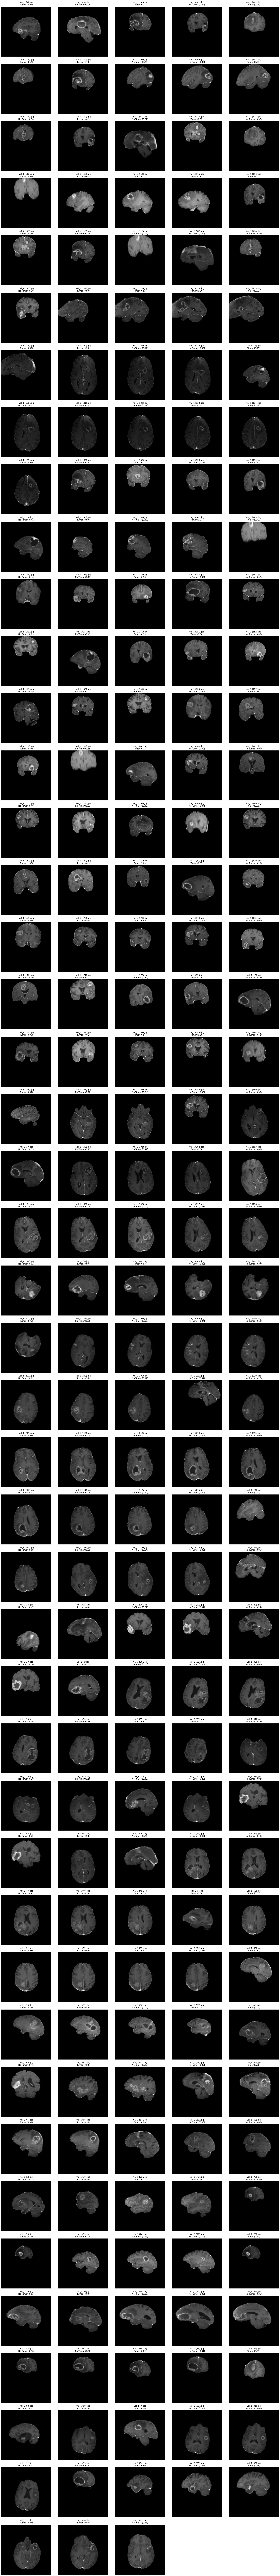

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tqdm import tqdm

# ====== STEP 1: Configuration ======
IMG_SIZE = 320
THRESHOLD = 0.5
EXTRACT_DIR = "/content/unseen_images"
MODEL_PATH = "/content/best_model.keras"

# ====== STEP 2: Load the Trained Model ======
clf_model = load_model(MODEL_PATH)

# ====== STEP 3: Preprocessing Function ======
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    h, w = img.shape
    scale = IMG_SIZE / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(img, (new_w, new_h))
    top = (IMG_SIZE - new_h) // 2
    bottom = IMG_SIZE - new_h - top
    left = (IMG_SIZE - new_w) // 2
    right = IMG_SIZE - new_w - left
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    rgb = np.repeat(padded[..., np.newaxis], 3, axis=-1)
    processed = preprocess_input(rgb.astype('float32'))
    return np.expand_dims(processed, axis=0)

# ====== STEP 4: Classification Pipeline ======
UNSEEN_SUBDIR = os.path.join(EXTRACT_DIR, "kaggle")
image_paths = sorted([os.path.join(UNSEEN_SUBDIR, f) for f in os.listdir(UNSEEN_SUBDIR)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

predictions = []
probabilities = []
image_paths_valid = []

print(f"\n🧪 Processing {len(image_paths)} unseen test images...\n")

for path in tqdm(image_paths):
    img_name = os.path.basename(path)
    img_tensor = preprocess_image(path)

    if img_tensor is None:
        print(f" ⚠️ Skipped: {img_name} (could not load)")
        continue

    prob = clf_model.predict(img_tensor, verbose=0)[0][0]
    label = int(prob >= THRESHOLD)

    predictions.append(label)
    probabilities.append(prob)
    image_paths_valid.append(path)

    print(f" 📷 {img_name} | Tumor Probability: {prob:.4f} → {'Tumor' if label else 'No Tumor'}")

# ====== STEP 5: Visualization Function ======
def visualize_predictions(image_paths, predictions, probs):
    num_images = len(image_paths)
    cols = 5
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(20, rows * 4))
    for i in range(num_images):
        img_path = image_paths[i]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        label = "Tumor" if predictions[i] else "No Tumor"
        plt.title(f"{os.path.basename(img_path)}\n{label} ({probs[i]:.2f})", fontsize=10)
    plt.tight_layout()
    plt.show()

# ====== Visualize All ======
visualize_predictions(image_paths_valid, predictions, probabilities)
